### Pytorch basics

In [ ]:
import torch
import torchvision

In [9]:
a = torch.tensor([1,2,3], dtype = torch.double)

In [12]:
print(a)
print(a.dtype)

tensor([1., 2., 3.], dtype=torch.float64)
torch.float64


In [18]:
b = torch.tensor([[2,3,4], [5,6,7]], dtype = torch.float)

In [20]:
print(b)
print(b.mean())
print(b.std())

tensor([[2., 3., 4.],
        [5., 6., 7.]])
tensor(4.5000)
tensor(1.8708)


In [21]:
b.view(3,2)

tensor([[2., 3.],
        [4., 5.],
        [6., 7.]])

In [24]:
b.view(1,-1) # infers col automatically

tensor([[2., 3., 4., 5., 6., 7.]])

In [37]:
b.shape

torch.Size([2, 3])

In [74]:
r = torch.rand(2,2)
r

tensor([[0.4321, 0.1560],
        [0.4499, 0.7626]])

In [45]:
r = torch.randn(4,4) # normal dist with mean 0 and variance 1
r

tensor([[-0.0737,  0.8843, -0.5612, -0.0573],
        [-0.8928,  0.9917,  0.2998,  0.7576],
        [ 1.0033,  1.1438,  0.8443, -0.7445],
        [ 1.1022, -0.1024,  0.9517,  0.4518]])

In [75]:
rint = torch.randint(1, 10, (2,2))
print(rint, rint.shape)

tensor([[3, 9],
        [8, 1]]) torch.Size([2, 2])


In [62]:
torch.numel(rint)

4

In [63]:
print(torch.ones(2,2))
print(torch.zeros(2,3))

tensor([[1., 1.],
        [1., 1.]])
tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [64]:
torch.randn_like(rint, dtype=torch.float)

tensor([[-0.1684, -2.3949],
        [ 0.8570,  1.2331]])

In [73]:
torch.add(torch.randint(1,10,(2,2)), torch.randint(1,10,(2,2)))

tensor([[ 7, 11],
        [14, 15]])

In [76]:
 r.add_(rint)

tensor([[3.4321, 9.1560],
        [8.4499, 1.7626]])

In [77]:
r

tensor([[3.4321, 9.1560],
        [8.4499, 1.7626]])

# Building a Seq2Seq model

In [469]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
import itertools

In [470]:
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

### Data Preprocessing

In [471]:
lines_filepath = os.path.join("cornell movie-dialogs corpus", "movie_lines.txt")
conv_filepath = os.path.join("cornell movie-dialogs corpus", "movie_conversations.txt")

In [472]:
line_fields = ['lineID', 'characterID', 'movieID', 'character', 'text']
linesObj = {}
with open(lines_filepath, "r", encoding="iso-8859-1") as file:
    lines = file.read().strip().split("\n")
    for line in lines:
        values = line.split(' +++$+++ ')
        lineObj = {}
        for i,d in enumerate(line_fields):
            lineObj[d] = values[i]
        linesObj[lineObj['lineID']] = lineObj

In [473]:
conv_fields = ['char1ID', 'char2ID', 'movieID', 'lineIDs']
convList = []
with open(conv_filepath, "r", encoding="iso-8859-1") as file:
    convs = file.read().strip().split("\n")
    for conv in convs:
        values = conv.split(' +++$+++ ')
        convObj = {}
        for i,d in enumerate(conv_fields):
            convObj[d] = values[i]
        lineIDs = eval(convObj['lineIDs'])
        convObj['lines'] = []
        for lineID in lineIDs:
            convObj['lines'].append(linesObj[lineID])
        convList.append(convObj)
# convList[0]
        

In [474]:
qa_pairs = []
for conv in convList:
    for i in range(len(conv['lines'])-1):
        input_line = conv['lines'][i]['text']
        target_line = conv['lines'][i+1]['text']
        if input_line and target_line:
            qa_pairs.append([input_line, target_line])

In [475]:
datafile = os.path.join("cornell movie-dialogs corpus", "formatted_movie_lines.txt")
delimiter = "\t"
# unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Write new csv file
with open(datafile, 'w', encoding='utf-8') as outputfile:
    write = csv.writer(outputfile, delimiter=delimiter)
    for pair in qa_pairs:
        write.writerow(pair)

In [476]:
datafile = os.path.join("cornell movie-dialogs corpus", "formatted_movie_lines.txt")
with open(datafile, 'rb') as file:
    lines = file.readlines()
for line in lines[:5]:
    print(line)

b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\r\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\r\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\r\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\r\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\r\n"


### Vocabulary class

In [477]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Vocabulary:
    def __init__(self, name):
        self.name = name
        self.word_index_map = {}
        self.word_count_map = {}
        self.index_word_map = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3
    
    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)
    
    def addWord(self, word):
        if word not in self.word_index_map:
            self.word_index_map[word] = self.num_words
            self.word_count_map[word] = 1
            self.index_word_map[self.num_words] = word
            self.num_words += 1
        else:
            self.word_count_map[word] += 1
    
    # Remove words below a threshold count
    def trim(self, min_count):
        keep_words = []
        for k, v in self.word_count_map.items():
            if v >= min_count:
                keep_words.append(k)
#         print(keep_words)
        # Reinitialize dicts
        self.word_index_map = {}
        self.word_count_map = {}
        self.index_word_map = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3
        
        for word in keep_words:
            self.addWord(word)
            
        

In [478]:
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [479]:
unicodeToAscii("Françoise")

'Francoise'

In [480]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [481]:
normalizeString("aa123aa!s's    dd?")

'aa aa !s s dd ?'

In [482]:
datafile = os.path.join("cornell movie-dialogs corpus", "formatted_movie_lines.txt")
lines = open(datafile, encoding='utf-8').read().strip().split('\n')

In [483]:
# May take some time
pairs = [[normalizeString(s) for s in pair.split('\t')] for pair in lines]

In [516]:
saved_pairs = pairs

In [517]:
voc = Vocabulary("cornell movie-dialogs corpus")

In [518]:
MAX_LENGTH = 10

In [519]:
def filterPair(p):
    return len(p[0].split()) < MAX_LENGTH and len(p[1].split()) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [521]:
pairs = [pair for pair in pairs if len(pair) > 1]
print("%d pairs in dataset" % len(pairs))

221293 pairs in dataset


In [522]:
pairs = filterPairs(pairs)
print("After filtering, there are %d pairs/conversations" % len(pairs))

After filtering, there are 64281 pairs/conversations


In [523]:
for pair in pairs:
    voc.addSentence(pair[0])
    voc.addSentence(pair[1])
print("Counted words:", voc.num_words)
# print(voc.word_index_map)
# for pair in pairs[:10]:
#     print(pair)

Counted words: 18008


In [524]:
MIN_COUNT = 3

In [525]:
def trimRareWords(voc, pairs, MIN_COUNT):
    voc.trim(MIN_COUNT)
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        for word in input_sentence.split(' '):
            if word not in voc.word_index_map:
                keep_input = False
                break
        for word in output_sentence.split(' '):
            if word not in voc.word_index_map:
                keep_output = False
                break
        if keep_input and keep_output:
            keep_pairs.append(pair)
    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs)/len(pairs)))
    return keep_pairs

temp_pairs = trimRareWords(voc, pairs, MIN_COUNT)

Trimmed from 64281 pairs to 53175, 0.8272 of total


In [526]:
pairs = temp_pairs

In [527]:
def indexesFromSentence(voc, sentence):
    return [voc.word_index_map[word] for word in sentence.split(' ')] + [EOS_token]

In [528]:
indexesFromSentence(voc, pairs[1][0])

[7, 8, 9, 10, 4, 11, 12, 13, 2]

In [529]:
inp = []
out = []
for pair in pairs:
    inp.append(pair[0])
    out.append(pair[1])
indexes = [indexesFromSentence(voc, sentence) for sentence in inp]
indexes

[[3, 4, 2],
 [7, 8, 9, 10, 4, 11, 12, 13, 2],
 [16, 4, 2],
 [8, 31, 22, 6, 2],
 [33, 34, 4, 4, 4, 2],
 [35, 36, 37, 38, 7, 39, 40, 41, 4, 2],
 [42, 2],
 [47, 7, 48, 40, 45, 49, 6, 2],
 [50, 51, 52, 6, 2],
 [58, 2],
 [61, 62, 6, 2],
 [65, 47, 40, 66, 2],
 [68, 7, 69, 70, 71, 6, 2],
 [34, 4, 2],
 [77, 6, 2],
 [79, 2],
 [76, 37, 86, 2],
 [5, 89, 7, 44, 6, 2],
 [50, 6, 2],
 [96, 97, 4, 98, 12, 99, 2],
 [100, 6, 2],
 [101, 102, 18, 12, 103, 104, 2],
 [7, 106, 107, 108, 109, 7, 24, 4, 2],
 [59, 60, 66, 2],
 [7, 110, 83, 111, 4, 2],
 [42, 61, 116, 117, 118, 40, 119, 4, 2],
 [91, 25, 2],
 [124, 125, 4, 76, 37, 126, 4, 2],
 [91, 34, 66, 2],
 [100, 6, 2],
 [53, 136, 6, 137, 138, 12, 119, 6, 2],
 [7, 53, 139, 140, 6, 2],
 [64, 142, 143, 7, 144, 6, 2],
 [145, 146, 4, 147, 148, 7, 6, 2],
 [147, 152, 150, 153, 96, 70, 154, 155, 6, 2],
 [156, 157, 4, 2],
 [158, 21, 66, 2],
 [147, 152, 150, 60, 159, 6, 2],
 [50, 75, 174, 6, 2],
 [76, 37, 12, 182, 183, 184, 2],
 [170, 185, 186, 2],
 [101, 37, 190, 66, 

In [530]:
def zeroPadding(l, fillvalue = 0):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

In [531]:
leng = [len(ind) for ind in indexes]
max(leng)

10

In [532]:
test_result = zeroPadding(indexes)
test_result

[(3,
  7,
  16,
  8,
  33,
  35,
  42,
  47,
  50,
  58,
  61,
  65,
  68,
  34,
  77,
  79,
  76,
  5,
  50,
  96,
  100,
  101,
  7,
  59,
  7,
  42,
  91,
  124,
  91,
  100,
  53,
  7,
  64,
  145,
  147,
  156,
  158,
  147,
  50,
  76,
  170,
  101,
  85,
  85,
  192,
  61,
  50,
  88,
  5,
  135,
  213,
  167,
  7,
  50,
  12,
  226,
  76,
  147,
  47,
  88,
  92,
  232,
  25,
  239,
  101,
  246,
  7,
  50,
  8,
  77,
  264,
  7,
  270,
  25,
  62,
  7,
  100,
  25,
  7,
  192,
  100,
  25,
  137,
  202,
  153,
  287,
  34,
  35,
  25,
  47,
  291,
  124,
  77,
  50,
  25,
  7,
  304,
  310,
  12,
  167,
  64,
  316,
  319,
  35,
  147,
  7,
  50,
  115,
  7,
  34,
  34,
  34,
  76,
  9,
  25,
  100,
  342,
  88,
  16,
  345,
  7,
  266,
  137,
  41,
  50,
  351,
  96,
  8,
  50,
  70,
  68,
  372,
  101,
  70,
  25,
  61,
  94,
  9,
  25,
  34,
  7,
  141,
  404,
  406,
  40,
  404,
  4,
  36,
  38,
  25,
  25,
  139,
  27,
  50,
  5,
  447,
  7,
  27,
  7,
  35,
  35,
  197,


In [533]:
def binaryMatrix(l, value=0):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

In [534]:
binary_result = binaryMatrix(test_result)
binary_result

[[1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


In [535]:
# returns padded input sequence tensor aas well as a tensor of lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

In [536]:
# Returns padding target sequence tensor, padding mask, and max target Length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

In [537]:
# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_length_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_length_len

In [538]:
#Example for validation
small_batch_size = 64
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("Input_variable:")
print(input_variable)
print("lengths:", lengths)
print("Target_variable:")
print(target_variable)
print("Mask:")
print(mask)
print("max_target_len:", max_target_len)

Input_variable:
tensor([[ 401,  167,  598,   25,   62, 6506,  274,   96,   47,   34,   36,    3,
            7,   64,  124,   47,   47,  219,  115,   53,  318,   76,  131, 3328,
           42,   64,   33, 1799,   68,    7,   25,   50,   25,   60,  304,  319,
          101,   76,   50,    7,  141, 1667, 3153,   36,  483,   59,   45,  147,
           36,  660,  785,   40,   34,  534, 2654,   53,   56,  383,  167,   79,
           16,   58, 6224, 4413],
        [ 177,    4,    7,  283,   36,  100,    4,   53,    7,   34,   37,  115,
         1972,  219,  125,   27,    7,   25,   76,  136,  281,  102,   25,   50,
          101,  100,   50,    6, 3027,  198,  197,  410,  200,  621,  305,  368,
           94,  379,  281,  527,  134,  650,   98,   37,   75,   37,  115,  102,
           37, 3657,   12,   77,  180,   76,  199,  989,  827,    7,    4,    4,
            4,   66,    4,    2],
        [5339,   25,    4,    7,   37,   92,  112, 2654,   18,    4, 1041,  319,
           92,   92,   25

## Building the Model Architecture

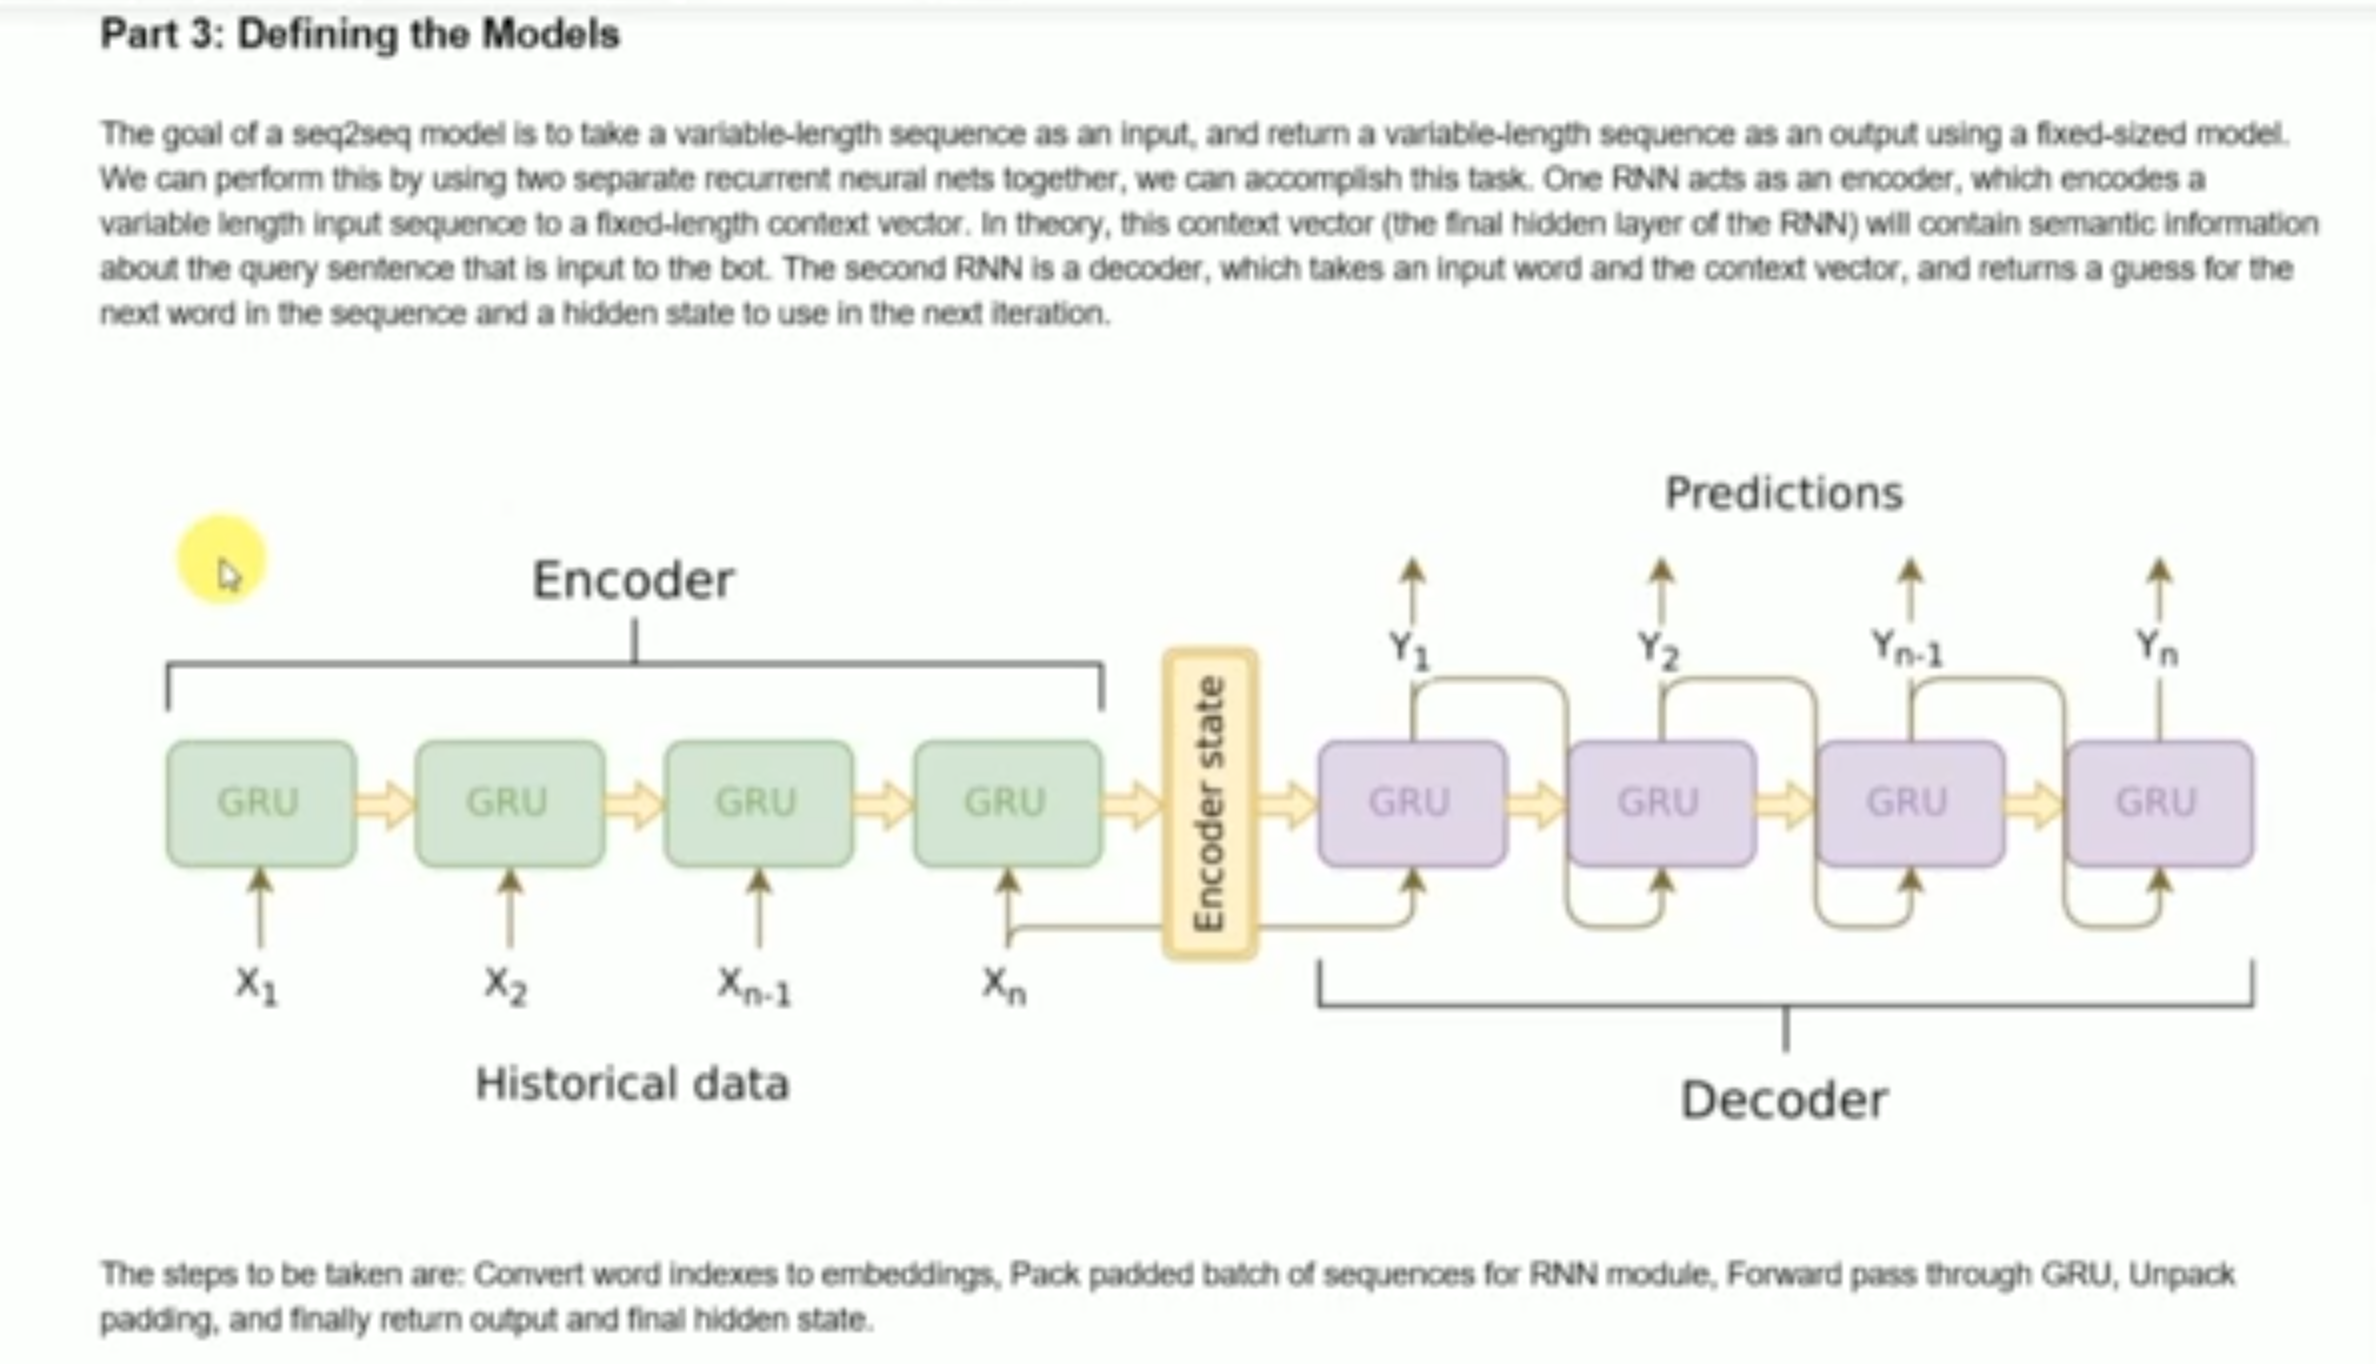

### Encoder

In [558]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        # Init GRU; input_size and hidden_size params are both set to 'hidden_size'
        # bcose our input_size is a word embedding with no of features -> hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers==1 else dropout), bidirectional=True)
        
    def forward(self, input_seq, input_lengths, hidden=None):
        embedded = self.embedding(input_seq)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        outputs = outputs[:, :, : self.hidden_size] + outputs[:, :, self.hidden_size :]
#         print("Encoder outputs shape", outputs.shape)
        return outputs, hidden

### Decoder

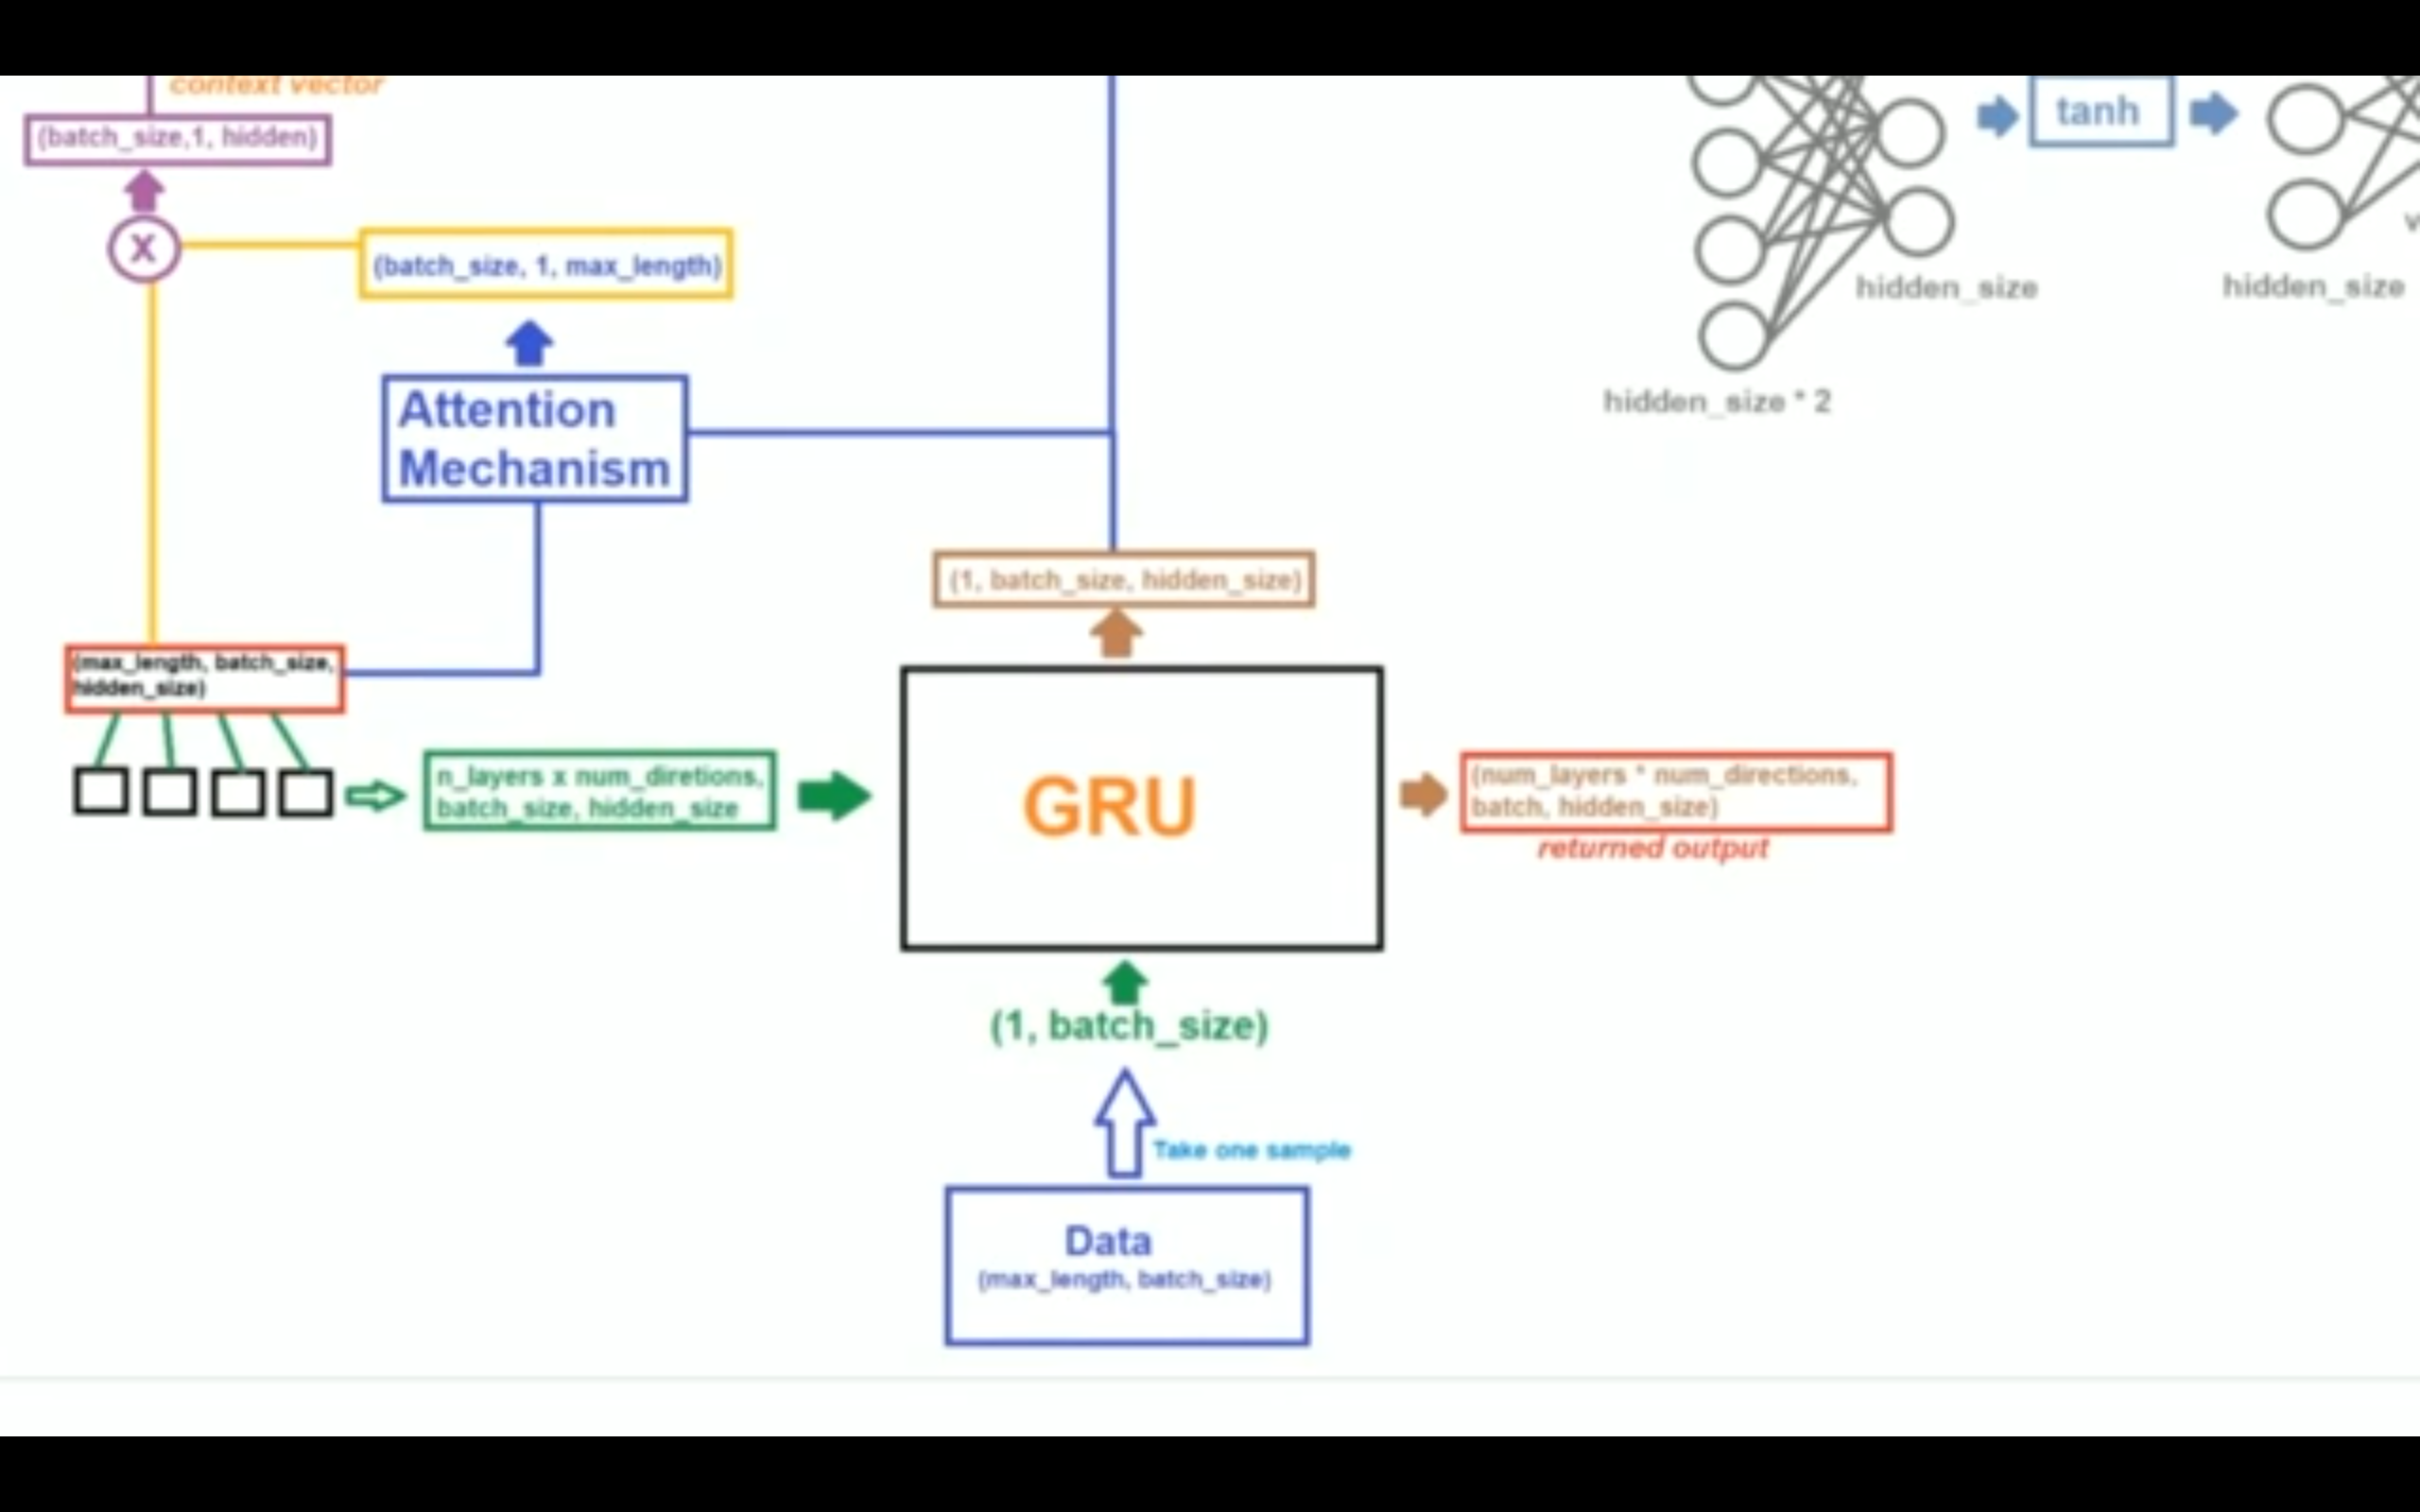

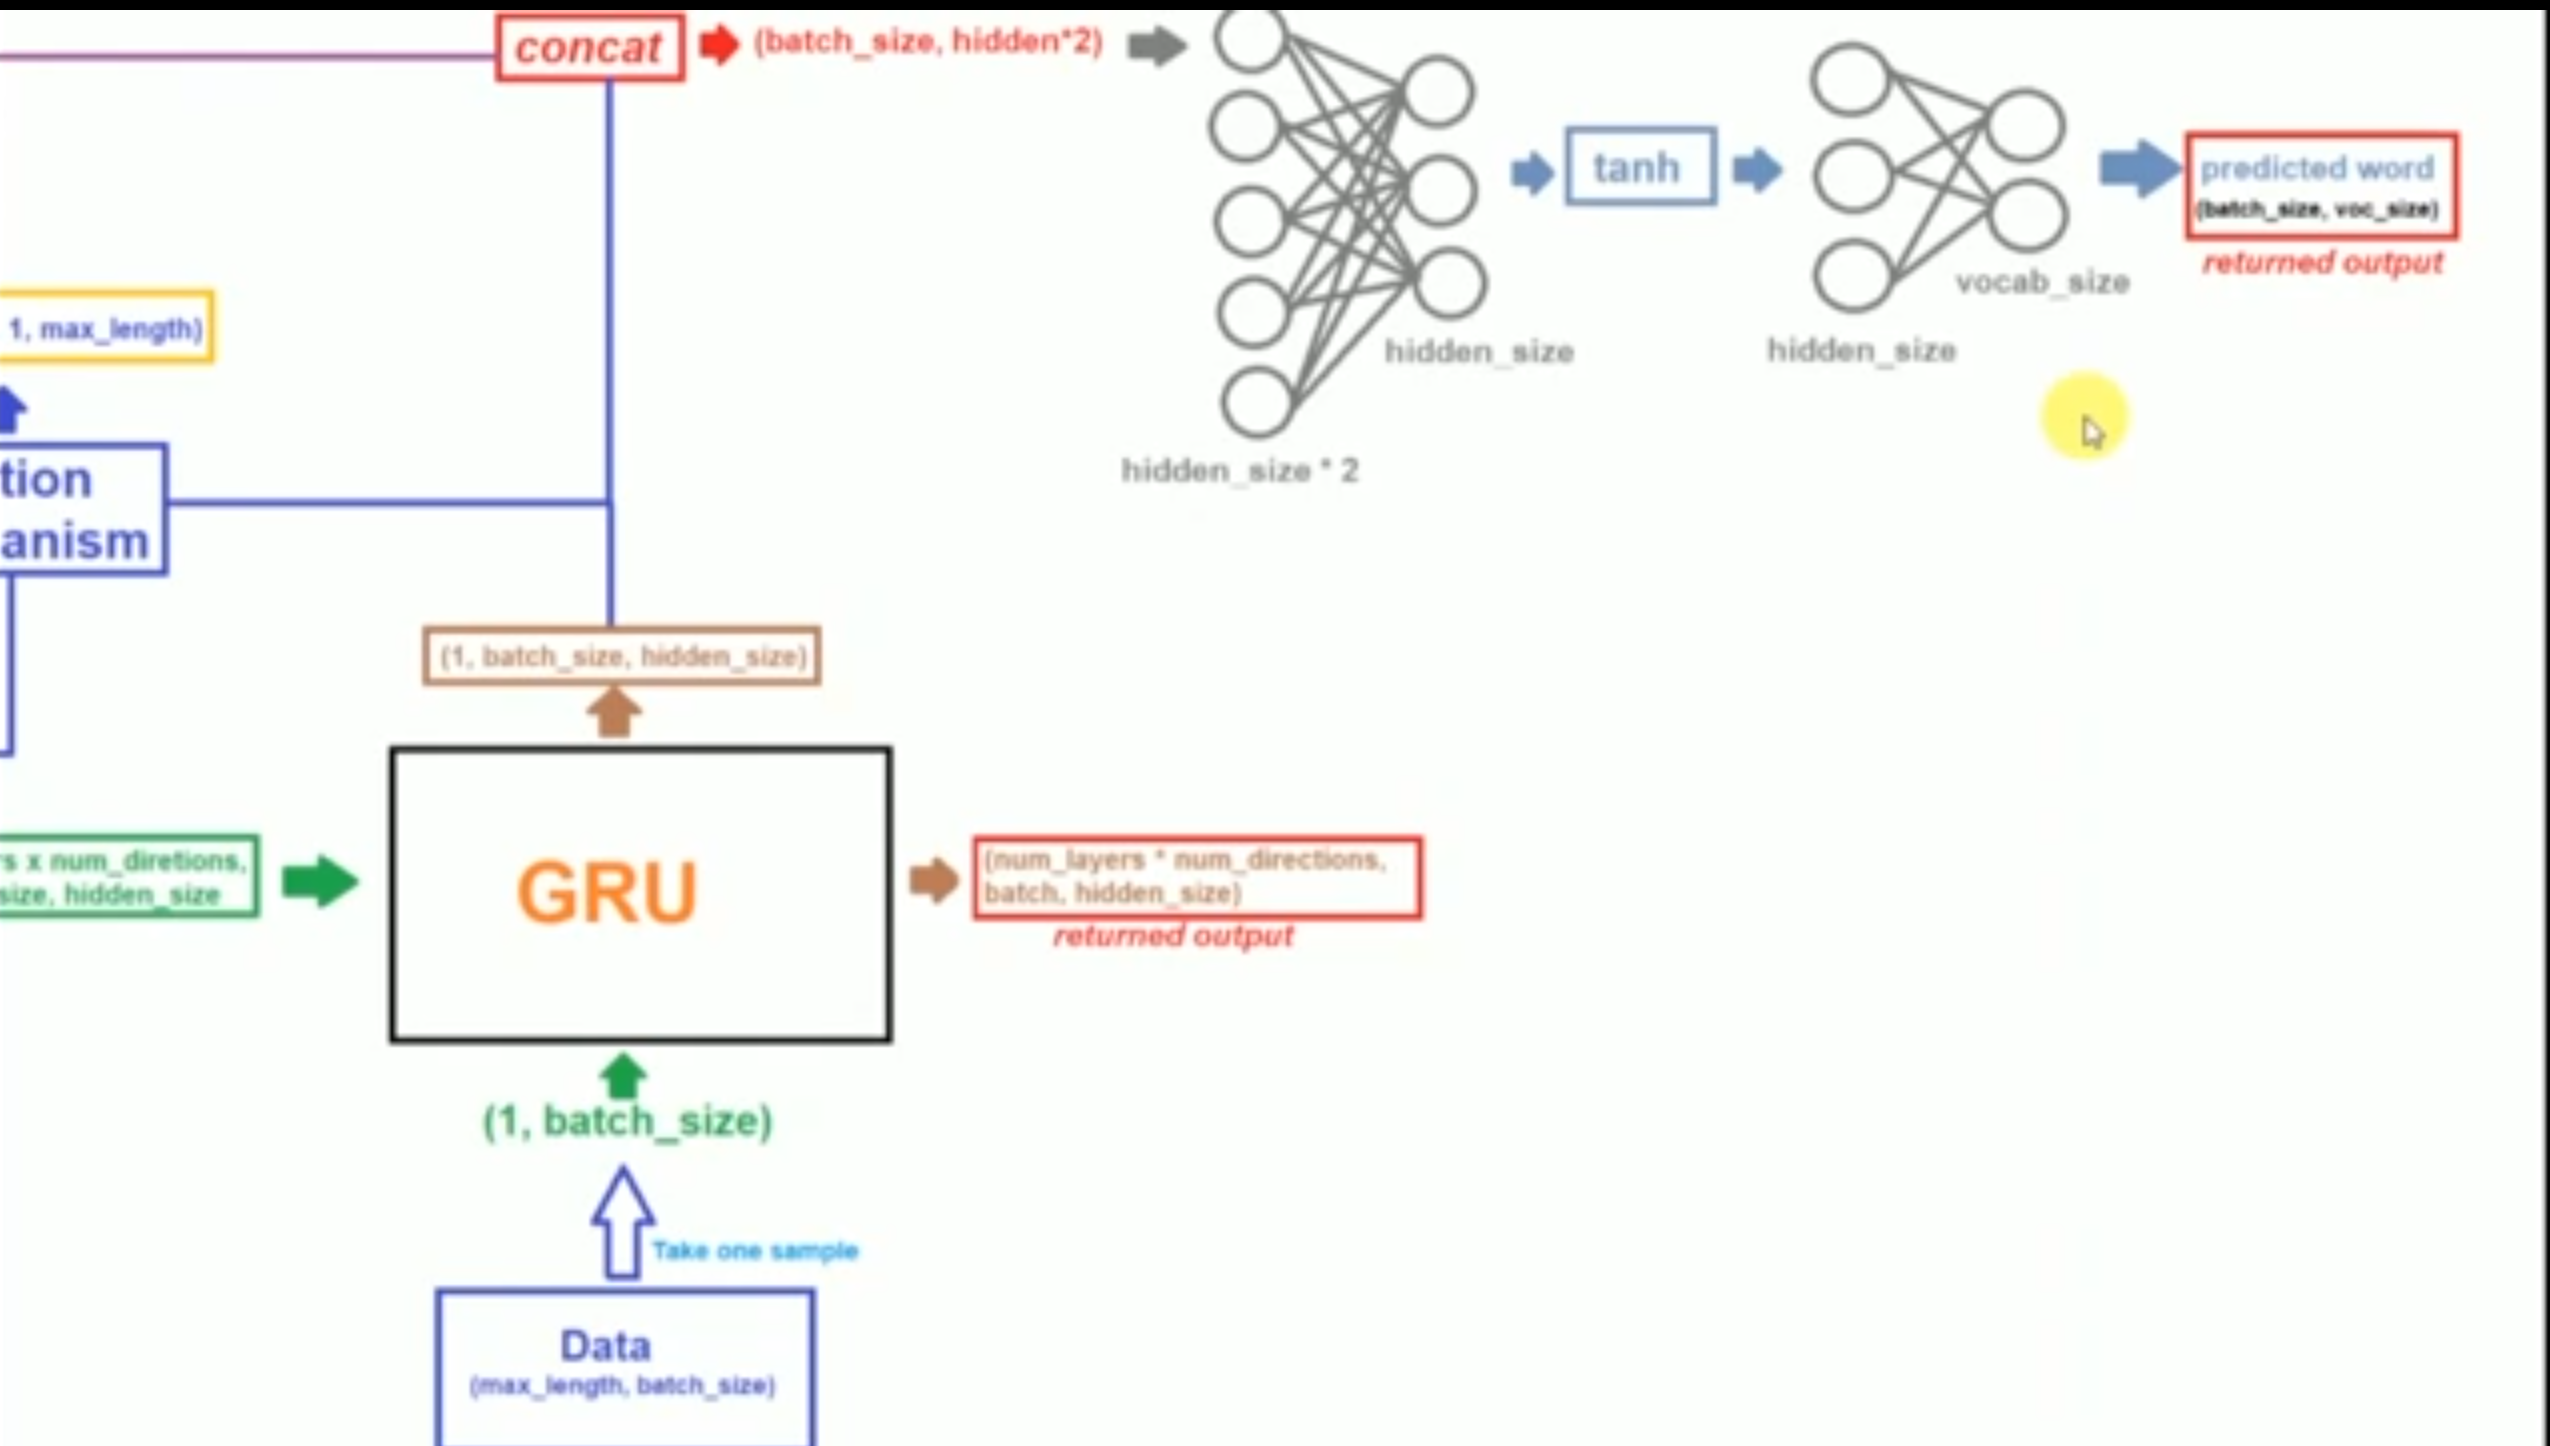

In [559]:
class Attention(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
    
    def dot_score(self, hidden, encoder_output):
        prod = hidden * encoder_output
        return torch.sum(prod, dim=2)
    
    def forward(self, hidden, encoder_outputs):
        # calc attention weights (energies)
        attn_energies = self.dot_score(hidden, encoder_outputs)
        # transpose for softmax
        attn_energies = attn_energies.t()
        # run softmax across columns (max_length) and add a dimension
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [560]:
class LuongAttentionDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttentionDecoderRNN, self).__init__()
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size*2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        self.attn = Attention(attn_model, hidden_size)
        
    def forward(self, input_step, last_hidden, encoder_outputs):
        # input_step      (1, batch_size)
        # last_hidden     (n_layers* num_directions, batch_size, hidden_size)
        # encoder_outputs (max_length, batch, num_directions* hidden_size)
        # Note: we run this one step (batch of words) at a time
        
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        
        # Calculate attn weights from current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        
        # Multiply attn weights with encoder_outputs
        # using batch multiply function in pytorch
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        
        # Concat weighted context vector and GRU output
        rnn_output = rnn_output.squeeze(0) # remove dim-1 from (1, batch_size, hidden_size)
        context = context.squeeze(1) # remove dim-1 from (batch_size, 1, hidden_size)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input)) # run through linear layer and take tanh
        
        # Predict next word
        output = self.out(concat_output)
        output = F.softmax(output, dim=1) # (batch_size, voc.num_words)
        return output, hidden
        

### Training Steps

In [561]:
def maskNLLLoss(decoder_out, target, mask):
    nTotal = mask.sum() # no of elements to consider
    target = target.view(-1,1)
    gathered_tensor = torch.gather(decoder_out, 1, target)
    crossEntropy = -torch.log(gathered_tensor)
    loss = crossEntropy.masked_select(mask)
    loss = loss.mean()
    loss = loss.to(device)
    return loss, nTotal.item()

### Training

In [562]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH, teacher_forcing_ratio=0.5):
    
    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initizalize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)
    
    # Create inital decoder input [start with SOS for each sentence]
    decoder_input = torch.LongTensor([[SOS_token for _ in range(small_batch_size)]])
    decoder_input = decoder_input.to(device)
    
    # Set initial decoder hidden state to encoder's final hidden state
    decoder_hidden = encoder_hidden[: decoder.n_layers]
    
    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    # Forward batch of sequence through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1,-1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    
    # Perform backpropagation
    loss.backward()
    
    # Clip gradients, in place (to prevent exploding gradient problem)
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    
    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    # return loss
    return_loss = sum(print_losses) / n_totals
    return return_loss 

    

In [563]:
small_batch_size = 64
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches
batch_size = small_batch_size

print("Input_variable:")
print(input_variable)
print("lengths:", lengths)
print("Target_variable:")
print(target_variable)
print("Mask:")
print(mask)
print("max_target_len:", max_target_len)

hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.5
attn_model = 'dot'
embedding = nn.Embedding(voc.num_words, hidden_size)

encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttentionDecoderRNN(attn_model, embedding, hidden_size, 
                                   voc.num_words, decoder_n_layers, dropout)
encoder = encoder.to(device)
decoder = decoder.to(device)
encoder.train()
decoder.train()
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

clip = 1
print_losses = []
num_iterations = 10
# for i in range(num_iterations):
# #     loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder, 
# #           decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, 
# #           clip, MAX_LENGTH)
# #     print(loss)
# #     print_losses.append(loss)
    
#     ################
#     ###### Trial Code ####    
    
#     save_every = 1
#     iteration = i
    
#     # Run a training iteration with batch
#     loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
#                  decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
#     print_losses.append(loss)


#     # Save checkpoint
#     if (iteration % save_every == 0):
#         save_dir = '.'
#         corpus_name = 'cornell movie-dialogs corpus'
#         directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
#         if not os.path.exists(directory):
#             os.makedirs(directory)
#         torch.save({
#             'iteration': iteration,
#             'en': encoder.state_dict(),
#             'de': decoder.state_dict(),
#             'en_opt': encoder_optimizer.state_dict(),
#             'de_opt': decoder_optimizer.state_dict(),
#             'loss': loss,
#             'voc_dict': voc.__dict__,
#             'embedding': embedding.state_dict()
#         }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))
    
    ################
    

Input_variable:
tensor([[  61,  511,   33,   50,    7,   50,   33,   92,   92,  219,  167,  101,
            7,  197,   12,   25, 2732, 4907,   45,    3,   25,  147,    7,  334,
            7,   64,  649,   27,   68,    7,  100,   34,   36,    7,  100,  334,
            7,   86,   33, 7717, 2444,   25,   25,  385,   25,   88,   25,  159,
          122,   25,   92, 2763,   25, 1227,    7,  601,   25, 1734,  199,  303,
          525,   50,   34,  318],
        [  37,   40, 1214,  281,   94,  175,   50,    7,    7,   68,   42,  102,
           47,  117, 5562,  197,    4, 2271,  115,   37,  250,   25,  260, 4449,
           24,    7,    6,   94,   65,   47,  247,  180,   25,  260,   92,   36,
         3236, 2453,    6, 7717,   36,  148,  553,  135,  527,    4,  387,   27,
           36,   89,    7,   37,  102,   83,   18,   66,   24,  276, 5377,    4,
            4,    6,    6,    4],
        [  29,   60,    4,    7,  117,    7,   47, 2181,  123,    7,   25,  620,
           18,    4,  755

In [564]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, 
embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, 
save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
#     n_iteration = 10
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

#### Greedy decoding

Greedy decoding is the decoding method that we use during training when we are NOT using teacher forcing. In other words, for each time step, we simply choose the word from decoder_output with the highest softmax value. This decoding method is optimal on a single time-step level.

To facilite the greedy decoding operation, we define a GreedySearchDecoder class. When run, an object of this class takes an input sequence (input_seq) of shape (input_seq length, 1), a scalar input length (input_length) tensor, and a max_length to bound the response sentence length. The input sentence is evaluated using the following computational graph:

Computation Graph:

        Forward input through encoder model.
        Prepare encoder’s final hidden layer to be first hidden input to the decoder.
        Initialize decoder’s first input as SOS_token.
        Initialize tensors to append decoded words to.

        Iteratively decode one word token at a time:
                Forward pass through decoder.
                Obtain most likely word token and its softmax score.
                Record token and score.
                Prepare current token to be next decoder input.

        Return collections of word tokens and sco

In [565]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [573]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index_word_map[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

### Run model

In [568]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0005
decoder_learning_ratio = 5.0
n_iteration = 400
print_every = 10
save_every = 20

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# # If you have cuda, configure cuda to call
# for state in encoder_optimizer.state.values():
#     for k, v in state.items():
#         if isinstance(v, torch.Tensor):
#             state[k] = v.cuda()

# for state in decoder_optimizer.state.values():
#     for k, v in state.items():
#         if isinstance(v, torch.Tensor):
#             state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)


Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 10; Percent complete: 2.5%; Average loss: 0.8961
Iteration: 20; Percent complete: 5.0%; Average loss: 6.7410
Iteration: 30; Percent complete: 7.5%; Average loss: 4.4537
Iteration: 40; Percent complete: 10.0%; Average loss: 4.5504
Iteration: 50; Percent complete: 12.5%; Average loss: 4.4626
Iteration: 60; Percent complete: 15.0%; Average loss: 4.5045
Iteration: 70; Percent complete: 17.5%; Average loss: 4.3449
Iteration: 80; Percent complete: 20.0%; Average loss: 4.3007
Iteration: 90; Percent complete: 22.5%; Average loss: 4.2091
Iteration: 100; Percent complete: 25.0%; Average loss: 4.3347
Iteration: 110; Percent complete: 27.5%; Average loss: 4.3081
Iteration: 120; Percent complete: 30.0%; Average loss: 4.2432


KeyboardInterrupt: 

In [569]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.4
batch_size = small_batch_size

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 120
loadFilename = os.path.join(save_dir, model_name, corpus_name,
                           '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                           '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttentionDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [574]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

In [ ]:
# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)


> who
Bot: i .
> who are you?
Bot: i .
> why do you say that?
Bot: i .
> adasasasasasd
Error: Encountered unknown word.
> what are you doing?
Bot: i .


### This is not working for now, it is only a skeleton